# Final Project - Detecting Fraudulent Credit Card Transactions

| Course | Term | Section | Group | Objective | Kaggle URL |
| --- | --- | --- | --- | --- | --- |
| W207 | Fall 2022 | 11 | 2 | Detect fraudulent credit card transactions | IEEE-CIS Fraud Detection ([Link](kaggle.com/competitions/ieee-fraud-detection)) |

**Group Members**
- Naikaj Pandya
- Chase Madson
- Eric Danforth


## I. Setup

### A. Import Packages

In [1]:
# Import necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
from math import floor
sns.set(style="darkgrid")  # default style

# For fitting the baseline KNN model
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

### B. Load Data

In [2]:
train_identity = pd.read_csv('data/train_identity.csv')
train_transaction = pd.read_csv('data/train_transaction.csv')
test_identity = pd.read_csv('data/test_identity.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')

## II. Exploratory Data Analysis

### A. Background Info and Summary of Data

This competition involves the application of machine learning neural networks to determine fraudulent credit card transactions. The aim of the project is to train a model on credit card activity dataset from Vesta and use it to determine which transactions in the test data are likely to be fraudulent. This competition is hosted by IEEE-CIS (IEEE Computational Intelligence Society) and the Vesta corporation, the world's leading payment service company.  

The data comes primarily from Vesta in terms of 2 tables: the transaction table and the identity table:  

* The transaction table is a list of each transaction with attributes such as transaction ID, transaction amount, card issue company, product purchased, etc. Along with these, there are a large number of "masked" fields in which the data is masked/encoded or the column name is masked. We believe that these masked data fields contain valuable information like currency of transaction, latitude/longitude of transaction, etc. Evaluation of these is not included for developing the baseline model, but will be used for the final model. The transaction table has the important column `isFraud` which is 1 if the transaction is a fraud and is 0 if it is not. This is our target column. The transaction table is the primary table with 1.97m rows split into train and test dataset, having 590,540 rows and 506,691 rows.  

* Next, the Identity table is a much smaller table when compared to the transaction table. This table includes a number of fields that are masked/encoded because they provide identifying features. The Identity dataset has a total of 286k rows split into train and test datasets having 144,233 rows and 141,907 rows, respectively. The identity table rows can be mapped to the transaction table using the transactionID column.  

### B. First Look at the Data

This data is collected by Vesta’s fraud protection system and digital security partners (the sponsors of this competition).

In [3]:
tmp_dict = {
 name:{
    'Transactions': len(df), 
    'Features': len(df.columns),
    'Date Range': [floor(i / (60 * 60 * 24)) - 1 for i in (df['TransactionDT'].min(), df['TransactionDT'].max())] 
                  if 'TransactionDT' in df else '',
    }
 for df, name
 in zip(
   (train_transaction, test_transaction, train_identity, test_identity),
   ('train_transaction', 'test_transaction', 'train_identity', 'test_identity')
   )
}

pd.DataFrame.from_dict(tmp_dict, dtype='str')

,train_transaction,test_transaction,train_identity,test_identity
Transactions,590540,506691,144233,141907
Features,394,393,41,41
Date Range,"[0, 181]","[212, 394]",,


#### Takeaways  

* **Big Data**: We have over half a million records of card transactions in each of `train_transaction` and `test_transaction` datasets, and a maximum of 434 features to work with

- **Differing Transaction Date Ranges**: The transaction dates in `training_transaction` appear to cover a 181-day time period starting at day 0, while the transaction dates in `test_transaction` appear to cover a 182-day time period starting at day 212  
    - The training and test data do not overlap in time
    - Though the data publishers deliberately mask the dates of this data, we infer that Day 0 is June 1, 2018 based on timing of the competition the apparent choice to omit December as an outlier holiday month

### C. Missing Data

In [4]:
tmp_dict = {
 name:{
    'Percent of all Values that are Null': f'{(len(df) - df.count()).sum() / (df.shape[0] * df.shape[1]):.1%}',
    'Total Features': df.shape[1],
    'Features w/ Nulls': df.isnull().any().sum(),
    'Features w/ > 50% Nulls': (df.count() < (len(df) * 0.5)).values.sum(),
    'Features w/ > 80% Nulls': (df.count() < (len(df) * 0.2)).values.sum(),
    }
 for df, name
 in zip(
   (train_transaction, test_transaction, train_identity, test_identity),
   ('train_transaction', 'test_transaction', 'train_identity', 'test_identity')
   )
}

pd.DataFrame.from_dict(tmp_dict, dtype='str')

,train_transaction,test_transaction,train_identity,test_identity
Percent of all Values that are Null,41.1%,36.9%,35.6%,36.2%
Total Features,394,393,41,41
Features w/ Nulls,374,345,38,38
Features w/ > 50% Nulls,174,170,12,15
Features w/ > 80% Nulls,55,52,9,9


#### Takeaways  

* **Missing Data**: Almost all the columns include some portion of missing data, which may need to be addressed before our final model  
    - Since we are looking to build the baseline model, we will do no missing value imputation and instead work only with features without null values

### D. Outcome Variable - `isFraud`

In [5]:
print(f'Percent Fraudulent: {train_transaction.isFraud.sum() / len(train_transaction):.3%}')

Percent Fraudulent: 3.499%


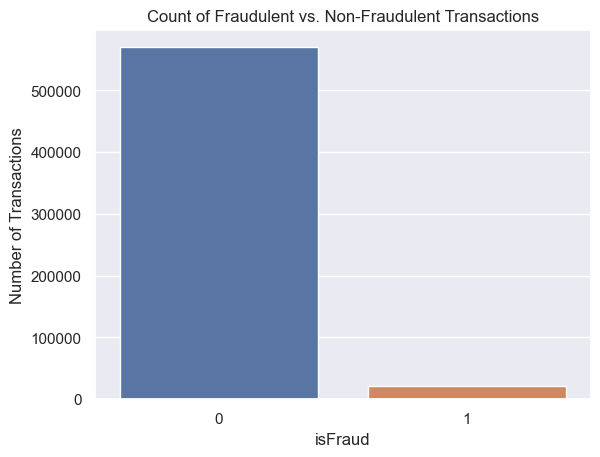

In [6]:
(sns.countplot(data=train_transaction, x='isFraud')
    .set(ylabel='Number of Transactions',
         title='Count of Fraudulent vs. Non-Fraudulent Transactions')
    );

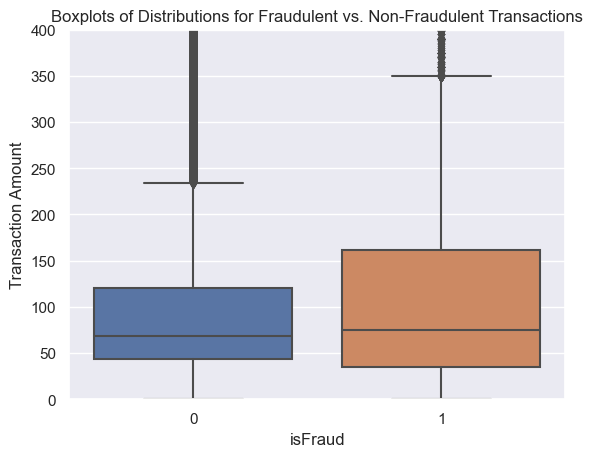

In [7]:
boxplot = sns.boxplot(data=train_transaction, x='isFraud', y='TransactionAmt')
boxplot.axes.axis(ymin=0, ymax=400)
boxplot.set_ylabel('Transaction Amount')
boxplot.set_title('Boxplots of Distributions for Fraudulent vs. Non-Fraudulent Transactions')
boxplot;

#### Takeaways  

* **Imbalanced Outcome Variable**: Only 3.5% of transactions are marked fraud, so we may want to account for this during training - we should be cautious of accuracy as a metric
    - One strategy: Downsample the majority class (i.e., not-fraud transactions) in the training data to build the model, then test the model against a normal test set.  


- **Difference in Transaction Amounts**: The distribution of fraudulent transactions appear to be somewhat greater than for the transactions not marked as fraud. This feature should be included in the model. 

### E. Identity Table

In [8]:
(train_transaction[['TransactionID']]
    .merge(train_identity.iloc[:,range(2)], on='TransactionID', how='left')
    .assign(have_identity=lambda df: ~pd.isna(df['id_01']))
    .groupby('have_identity')
    .count()
    )

,TransactionID,id_01
have_identity,,
False,446307,0
True,144233,144233


#### Takeaways  

* The transactions in `train_identity` are a subset of the transactions in `train_transaction`, as is `test_identity` to `test_transaction` 
* About 25% of the transactions in `training_transaction` have a corresponding record in `training_identity`
* Because joining `training_identity` features to `training_transaction` will introduce a lot of `NULL` values, we will simply create a binary variable `have_identity` to indicate whether a transaction appears in both tables

## III. Training the Baseline Model with KNN

### A. Handling Missing Data
We defer the handling of missing values at this stage by dropping any column containing nulls.

In [9]:
preprocessed_data = train_transaction[
    train_transaction.columns[
        (train_transaction.count() == len(train_transaction)).values
    ]
]

preprocessed_data_test = test_transaction[
    train_transaction.columns[
        (train_transaction.count() == len(train_transaction)).values
    ]
    .drop('isFraud')
]

preprocessed_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,2987000,0,86400,68.5,W,13926,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,2987001,0,86401,29.0,W,2755,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,2987002,0,86469,59.0,W,4663,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2987003,0,86499,50.0,W,18132,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,2987004,0,86506,50.0,H,4497,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


### B. Preprocessing: Normalization

Considering the magnitude of the `TransactionDT` and `TransactionAmt` variables, we wish to normalize these to between [-1, 1] to avoid skewing our KNN results.

In [10]:
preprocessed_data = preprocessed_data.assign(
    TransactionAmt=lambda df: df["TransactionAmt"] / df["TransactionAmt"].max(), 
    TransactionDT=lambda df: df["TransactionDT"] / df["TransactionDT"].max()
    )
    
preprocessed_data_test = preprocessed_data_test.assign(
    TransactionAmt=lambda df: df["TransactionAmt"] / df["TransactionAmt"].max(), 
    TransactionDT=lambda df: df["TransactionDT"] / df["TransactionDT"].max()
    )

preprocessed_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,2987000,0,0.005465,0.002145,W,13926,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,2987001,0,0.005465,0.000908,W,2755,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,2987002,0,0.005469,0.001847,W,4663,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2987003,0,0.005471,0.001566,W,18132,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,2987004,0,0.005471,0.001566,H,4497,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


### C. Drop Categorical Variables and Primary Key

Along with dropping our primary key `TransactionID`, we drop all our categorical variables to defer one-hot encoding.

In [11]:
preprocessed_data = (
    preprocessed_data
        .drop(['TransactionID', 'ProductCD', 'card1'], axis=1)
)

preprocessed_data_test=preprocessed_data_test.drop(['ProductCD','card1'],axis=1)
preprocessed_data.head()

,isFraud,TransactionDT,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,0,0.005465,0.002145,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,0,0.005465,0.000908,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,0,0.005469,0.001847,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,0,0.005471,0.001566,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,0,0.005471,0.001566,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


### D. Test-Train Split

Now we split the data for testing and training.

In [12]:
train, test = train_test_split(preprocessed_data)

### E. Subsetting Training Data

We train on a sample of the data for speed and to address class imbalance.

In [13]:
def subset_training(df, stratify):
    if stratify:
        # Stratified sample to balance training set
        return df.groupby('isFraud').sample(12500)
    else:
        # If we just want a simple random sample
        return df.sample(25000)

# Split the data
train = subset_training(train, stratify=True)

# Separate the feature space from the outcome variable in training and test sets
y_train = train['isFraud']
X_train = train.drop('isFraud', axis=1)
y_test = test['isFraud']
X_test = test.drop('isFraud', axis=1)

# Drop unnecessary tables
del preprocessed_data, train, test

### F. Train the Model

We choose the *KNN algorithm* to build our baseline model with the feature space: `TransactionDT`, `TransactionAmt`, `C1`, `C2`, ..., `C14`

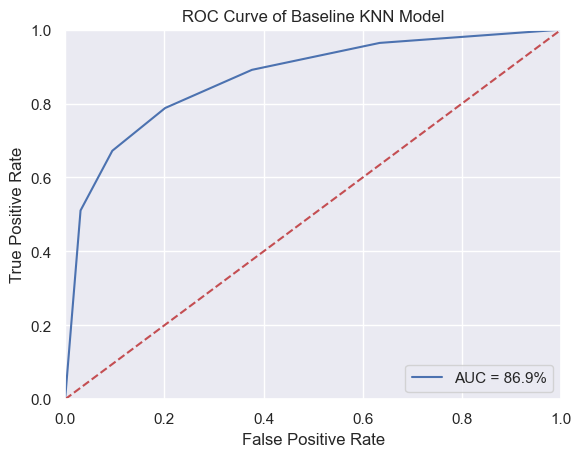

In [14]:
knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(X_train, y_train)

y_scores = knn.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:.1%}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Baseline KNN Model')
plt.show()

In [15]:
# Compute the KNN predictions on records with no null values (takes 3-5 minutes)
isFraudKNN = knn.predict_proba(
    preprocessed_data_test
    .dropna()
    .drop('TransactionID', axis=1)
)

# Format the KNN predictions back into a 2-column DataFrame with transaction IDs
isFraudKNN = pd.concat(
    [
    # Series of transaction IDs after dropping test rows with null values
    preprocessed_data_test.dropna().TransactionID.reset_index(drop=True), 

    # Series of predictions after dropping test rows with null values
    pd.Series(isFraudKNN[:, 1], name='isFraudProbability')
    ],

    # Concatenate these Series as columns into a DataFrame
    axis=1
)

# We will set the default probability to the average fraud rate of training set
fraud_rate_training = train_transaction.isFraud.mean()

# Create a DataFrame with predictions for submissions
knn_baseline_submission = (

    # Start with all test transaction IDs
    test_transaction[['TransactionID']]

    # Left join the predictions
    .merge(isFraudKNN, how='left', on='TransactionID')

    # Set records that don't have a KNN prediction to a default probability
    .fillna(fraud_rate_training) 
)

# Print the first few rows
print(knn_baseline_submission.head())

# Write to a CSV file for submission
knn_baseline_submission.to_csv('data/submissions/knn_baseline.csv', index=False)

   TransactionID  isFraudProbability
0        3663549                 0.0
1        3663550                 0.2
2        3663551                 0.2
3        3663552                 0.6
4        3663553                 0.0


Submitted 11/6
* Public score: 0.824696
* Private score: 0.786839